# Neural & Behavioral Modeling - Week 5 (Exercises)
by 林子堯 (r08227112@ntu.edu.tw)

## 1 Replicate exisiting findings/models (10 points)
Based on your personal interest, please choose and replicate ONE of the following studies:

1. [Flocking Vee Formations](http://ccl.northwestern.edu/netlogo/models/FlockingVeeFormations) in NetLogo's [Sample Models::Biology] 

2. [Wolf-Sheep Predation](http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation) in NetLogo's [Sample Models::Biology] 

3. [MIT Matching Game](https://kknews.cc/zh-tw/news/p56pbrp.html)

4. Gray, K., Rand, D. G., Ert, E., Lewis, K., Hershman, S., & Norton, M. I. (2014). [The emergence of “us and them” in 80 lines of code: Modeling group genesis in homogeneous populations](http://www.mpmlab.org/groups/). Psychological Science, 25(4), 982-990.

5. Luhmann, C. C., & Rajaram, S. (2015). [Memory transmission in small groups and large networks: An agent-based model](http://journals.sagepub.com/doi/abs/10.1177/0956797615605798). Psychological Science, 26(12), 1909-1917.

6. Henriques, G. J., Simon, B., Ispolatov, Y., & Doebeli, M. (2019). [Acculturation drives the evolution of intergroup conflict](https://www.pnas.org/content/116/28/14089). Proceedings of the National Academy of Sciences, 116(28), 14089-14097.

此次作業中，我重製 Luhmann & Rajaram (2015) Memory transmission in small groups and large networks: An agent-based model 的研究結果。下文中分為兩個段落，一是依據論文中給的條件來設定 agent based modeling，二是重現 Luhmann & Rajaram 研究一的結果。


## Set Up Agent Model

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import *
from random import shuffle
from copy import *
from scipy import stats

與之先關的單詞也會移併手到每個 Agent (Subject) 包含兩個主要屬性以及兩個主要方法。前者包括 

- $\boldsymbol{A} = (A_1, \dots, A_40)^{\top} \in [0, 1]^{40}$: agent 對於 40 個記憶單詞題取出可能性 (activation)。
- $\boldsymbol{S} = (S_{ij})_{40 \times 40} \in [-0.2, 0.2]^{40 \times 40}$: 為記憶單詞之間的關聯強度 (association)。

後者的兩個方法有

- **收錄 (encode):** 當收錄一個單詞 $A_i$ 時，他會增加該單詞的 activation，其增加的幅度為 $\Delta{A_i} = \alpha (1 - delta{A_i})$。此外，如果該單詞
$A_i \neq max\{\boldsymbol{A}\}$，則最大可能性的單詞會被抑制 $\Delta A_{max} = -\beta A_{max}$，且其他相關的單詞也一同會被抑制 $\Delta A_j = -\beta S_{max, j} A_j, \; j \in \{1, \dots, 40\}/\{i, max\}$，只使被抑制的強度會與 $A_{max}$ 之間的關聯而有所調整。在最後，會重興 normalize 所有 {\boldsymbol{A}} 的 activatio，以保證 $\sum \boldsymbol{A} = 1}。
- **題取 (retrive):** Agent 會有 $\gamma$ 的機率能進入題取環節，如果進入題取環節後而每個單詞被提出來的機率也就根據它的 activation。之中還會判定單詞是否跟先前是否有重複，若該單詞 $A_item$ 沒有重複 (題取成功！) 到，則與之先關的單詞也受到題取詞的影響而增加其 activation，增加的幅度為 $\Delta A_j = \beta S_{item, j} A_j, \; j = \{1, \dots, 40\}/\{item\}$。

In [2]:
# Deifine person class
class Person:
    def __init__(self, Nitem, alpha, beta, gamma):
        # randomA = random.dirichlet(repeat(1, Nitem)) # randomly generate activation of N words
        # self.A = randomA / sum(randomA) # ensure sum(A) = 1
        self.A = random.dirichlet(repeat(1, Nitem))
        self.S = random.random((Nitem, Nitem)) * 0.4 - 0.2 # randomly generate inter-word association value in -0.2 ~ 0.2
        self.Nitem = Nitem
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.maxIndex = argmax(self.A)
        

    def encodeAnItem(self, item):
        encodeIndex = item
        if encodeIndex != self.maxIndex: # if encoded item is not the maximally activative item
            for i in range(self.Nitem):
                if i == encodeIndex:
                    self.A[i] += self.alpha * (1 - self.A[i]) # Equation (1)
                elif i == self.maxIndex:
                    self.A[i] -= self.beta * self.A[i] # Equation (2)
                else:
                    self.A[i] -= self.beta * self.S[self.maxIndex, i] * self.A[i] # Equation (3)
        else: # if encoded item is the maximally activative item
            self.A[encodeIndex] += self.alpha * (1 - self.A[encodeIndex]) # Equation (3)
        
        self.A = self.A / sum(self.A) # normalize A such that sum(A) = 1
        self.maxIndex = argmax(self.A) # update the index of maximum in A 


    def retriveAnItem(self, itemPrevious):
        item = NaN 
        if random.random(1) < self.gamma: # Pr(retriveAnItem) = gamma, Pr(failToRetriveAnItem) = 1-gamma
            item_onehot = random.multinomial(1, self.A)
            item = argmax(item_onehot)
        
        sucessfullyRetrive = not( isnan(item) | (item in itemPrevious) )
        if sucessfullyRetrive: # if sucessfull retive an item
            for j in range(self.Nitem): # enhance activation of association items
                if j == item: # except the retrive item
                    continue
                self.A[j] += self.beta * self.S[item, j] * self.A[j] # Equation (4)

        return(item, sucessfullyRetrive)            


下方則是建造一個群體 (task / group) 在實驗中可能進行方法。包括建造多少人的團體、進行多少回和數等等屬性。物件中的方法最重要的是能執行 1.「團題共同」(collaborative) 或是 2.「分別獨自」(isolative) 進行單詞題取與登錄，規範團體內的 agent 如何依序執行，以及剩下其他方法則是計算團體成員間 activation 的相似性 (similarity) 和總共能記起多少比例的單詞。

In [3]:
# Define task class
class Task:
    def __init__(self, Npeople, Nround, Nitem, alpha, beta, gamma):
        self.Npeople = Npeople
        self.Nround = Nround
        self.Nitem = Nitem
        self.people = [Person(Nitem = Nitem, alpha = alpha, beta = beta, gamma = gamma) for i in range(Npeople)]
        self.itemPrevious = []
            

    def collaborativeMemory(self):
        for i in range(self.Nround):
            order = list(range(self.Npeople))
            random.shuffle(order) # random retrival order in each round
            for k in order:
                itemCurrent, sucessfullyRetrive = self.people[k].retriveAnItem(self.itemPrevious)
                if sucessfullyRetrive:
                    self.itemPrevious.append(itemCurrent)
                    for j in range(Npeople): 
                        self.people[j].encodeAnItem(itemCurrent)
    

    def isolateMemory(self):
        itemPreviousGroup = []
        for k in range(self.Npeople):
            itemPreviousPerson = []
            for i in range(self.Nround):
                itemCurrent, sucessfullyRetrive = self.people[k].retriveAnItem(itemPreviousPerson)
                if sucessfullyRetrive:
                    itemPreviousPerson.append(itemCurrent)
                    self.people[k].encodeAnItem(itemCurrent)
            itemPreviousGroup = itemPreviousGroup + itemPreviousPerson
        self.itemPrevious = list(set(itemPreviousGroup))


    def getSimilarity(self):
        corrMatrix = corrcoef([self.people[i].A for i in range(self.Npeople)])
        similarity = mean(corrMatrix - eye(self.Npeople)) / 2.0 
        return(similarity)


    def getGroupRecallRate(self):
        groupRecallRate = len(self.itemPrevious) / self.Nitem
        return(groupRecallRate)

## Replicate The Result Of The Study 1

本次作業的目標是能複製出該研究的[圖 1(連結)](https://journals.sagepub.com/na101/home/literatum/publisher/sage/journals/content/pssa/2015/pssa_26_12/0956797615605798/20170718/images/large/10.1177_0956797615605798-fig1.jpeg)。然而其中要比較的是，如果團體共同進行記憶會使得整體記憶的單詞反而沒有分別獨自記起來的多。

下方則是模擬整個流程，其中的參數設置如同論文中的配置一樣，共同記憶組 (collaborate task) 與對照組 (nominal task) 都是三人一組，進行 20 回合題取與登錄單詞的流程。其中值得注意的是，由於我們是用 agent based modeling，我們可以設定這兩組的三人都是相同的三人，但分別操弄這兩種情境下他們最終的行為是否會異同。此外，每個人都有 40 的單詞得記，以及其他學習的參數 $\alpha = 0.2 \& \beta = 0.05$ 與題取進入機率 $\gamma = 0.75$ 也都是相同的。最後，上述的條件重複執行 1000 次的模擬。

In [5]:
# Set up the parameters
alpha = 0.2
beta = 0.05
gamma = 0.75
Nitem = 40
Nround = 20
Npeople = 3
Nsim = 1000

# Run simulation 
## creat collaborate task / nominal task
collaborate_tasks = [Task(Npeople = Npeople, Nround = Nround, Nitem = Nitem, alpha = alpha, beta = beta, gamma = gamma) for i in range(Nsim)]
nominal_tasks = deepcopy(collaborate_tasks) 

## get the precollaborate similarity between item's activation over people
collaborate_preSimilarity = array([collaborate_tasks[i].getSimilarity() for i in range(Nsim)])
nominal_preSimilarity = array([nominal_tasks[i].getSimilarity() for i in range(Nsim)])
collaborate_preSimilarityZscore = stats.zscore(collaborate_preSimilarity)
nominal_preSimilarityZscore = stats.zscore(nominal_preSimilarity)

## start (collaboratelly / isolately) retrival and encodeing
for i in range(Nsim):
    collaborate_tasks[i].collaborativeMemory()
    nominal_tasks[i].isolateMemory()

## get the postcollaborate similartiy between item's activation over people
collaborate_postSimilarity = array([collaborate_tasks[i].getSimilarity() for i in range(Nsim)])
nominal_postSimilarity = array([nominal_tasks[i].getSimilarity() for i in range(Nsim)])
collaborate_postSimilarityZscore = stats.zscore(collaborate_postSimilarity)
nominal_postSimilarityZscore = stats.zscore(nominal_postSimilarity)

## get the final recall rate in each group
collaborate_groupRecallRate = array([collaborate_tasks[i].getGroupRecallRate() for i in range(Nsim)])
nominal_groupRecallRate = array([nominal_tasks[i].getGroupRecallRate() for i in range(Nsim)])

最後結果如下所示：

In [11]:
def ttest_pairsample(x, y, alpha):
    nx, xbar, xsd = len(x), mean(x), std(x)
    ny, ybar, ysd = len(y), mean(y), std(y)
    df = nx - 1
    sd = std(x - y)

    tvalue = (xbar - ybar) / (sd / sqrt(nx))
    pvalue = 2 * (1 - stats.t.cdf(tvalue, df))
    CI = [(xbar-ybar) - stats.t.ppf((1-alpha/2), df)*(sd / sqrt(nx)), (xbar-ybar) + stats.t.ppf((1-alpha/2), df)*(sd / sqrt(nx))]
    d = (xbar-ybar) / sd
    
    print("========= Pair sample t test =========")
    print("mean of x = %.2f, mean of y = %.2f" % (xbar, ybar))
    print("t = %.2f, df = %i, p-value = %.3f" % (tvalue, df, pvalue))
    print("95%% C.I. = [%.3f, %.3f]" % (CI[0], CI[1]))
    print("Cohen's d = %.2f" % d)
    print("======================================")



In [12]:
ttest_twosample(nominal_groupRecallRate*40, collaborate_groupRecallRate*40, 0.05)

========= Two sample t test =========
mean of x = 17.06, mean of y = 11.41
t = 73.33, df = 1998, p-value = 0.000
95% C.I. = [5.493, 5.795]
Cohen's d = 3.28


若比較兩組回憶的單詞比例進行相依樣本的 t 檢定的話，在上述的設置下可以很明顯的發現，共同記憶下的組別平均的總記得數量顯著少於分別獨自記憶組的平均數量。結論與論文中的一致！但是在統計數值上我自己的模擬其實比論文中模擬的值要來的少一些，可以從下圖中得知。

<Figure size 864x432 with 0 Axes>

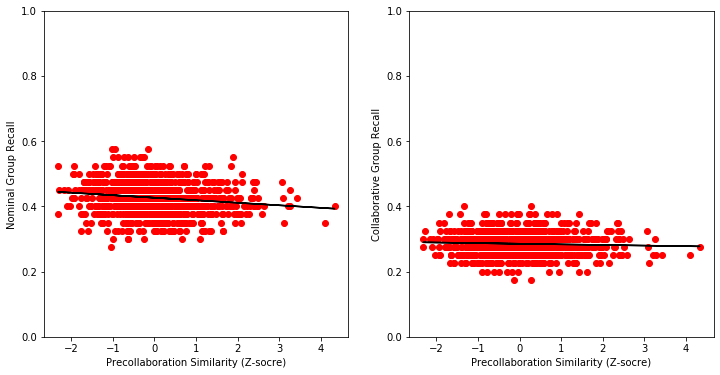

In [8]:
fig = figure(figsize = (6*2, 6))
rcParams["figure.figsize"] = (6*2, 6)
fig, axs = subplots(1, 2)

axs[0].plot(nominal_preSimilarityZscore, nominal_groupRecallRate, 'ro')
a, b = polyfit(nominal_preSimilarityZscore, nominal_groupRecallRate, deg=1)
y_est = a * nominal_preSimilarityZscore + b
axs[0].plot(nominal_preSimilarityZscore, y_est, 'k-')
axs[0].set_xlabel("Precollaboration Similarity (Z-socre)")
axs[0].set_ylabel("Nominal Group Recall")
axs[0].set_ylim([0,1])
axs[1].plot(collaborate_preSimilarityZscore, collaborate_groupRecallRate, 'ro')
a, b = polyfit(collaborate_preSimilarityZscore, collaborate_groupRecallRate, deg=1)
y_est = a * collaborate_preSimilarityZscore + b
axs[1].plot(collaborate_preSimilarityZscore, y_est, 'k-')
axs[1].set_xlabel("Precollaboration Similarity (Z-socre)")
axs[1].set_ylabel("Collaborative Group Recall")
axs[1].set_ylim([0,1])

rcParams["figure.figsize"] = (6, 4) 

在這邊我也重製論文中圖 1 的形式，分別看組內人員的相似性 (precollaboration similartiy) 以及最終的單詞記得率的散佈圖 (只是我並沒有像圖 1 般設置 jitter)。

首先可以發現，獨自記憶組 (nominal group) 的單詞記得率在 0.3 ~ 0.6 之間，明顯高於共同記憶組 (collaborate group) 單詞記得率在 0.2 ~ 0.4 之間；第二，不管是在那一組別，如果組員之間對於單詞的 activation 程度一開始相似程度高，最終他們單詞記得率也會較低，因此呈現負斜率的迴歸線；

比較缺憾的是，論文中獨自記憶組最終的單詞記得率約莫都在 0.5 ~ 0.8 間，而共同記憶組 (collaborate group) 單詞記得率則是在 0.3 ~ 0.5 之間。我自己做的 agent based model 在數值較低於原作者他們的結果，可能是在程式設定上還是有不完全一樣的地方，彩想可能是這邊設置題取新單詞的門檻可能比較高些，只是我也還不確定問題出在那。但這並不以想我們看到「題取引發遺忘」此顯像，尤其是群體共同一起來記憶，反而比獨自來抑制的還要更多！！